In [ ]:
%matplotlib inline
import matplotlib

In [ ]:
pip install qiskit qiskit-aer numpy scipy matplotlib pylatexenc

In [ ]:
!pip install --upgrade pip
!pip install iqm-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of iqm-exa-common to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of iqm-exa-common to 

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, partial_trace, entropy, entanglement_of_formation
from qiskit_aer import AerSimulator, StatevectorSimulator
from iqm.qiskit_iqm import IQMProvider
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

from qiskit.visualization import plot_histogram
import matplotlib

# Implementing Different States
Code to implement various circuits.

In [ ]:
def ghz_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)  # Start with Hadamard on first qubit

    # Apply CNOTs in a tree structure
    step = 1
    while step < n:
        for i in range(0, n, 2*step):
            if i+step < n:
                qc.cx(i, i+step)
        step *= 2
    return qc


def w_state_circuit():
    qc = QuantumCircuit(3, 3)
    theta = 2*np.arccos(1/np.sqrt(3))
    qc.ry(theta, 0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    return qc


def cluster_state_circuit(n=4):
    qc = QuantumCircuit(n, n)
    for i in range(n):
        qc.h(i)  # put all qubits in superposition
    for i in range(n-1):
        qc.cz(i, i+1)  # entangle neighbors
    return qc


def dicke_3_1_circuit():
    """Prepare |D^3_1> (3-qubit Dicke state with 1 excitation)"""
    qc = QuantumCircuit(3, 3)

    # Step 1: rotate qubit 0
    theta = 2*np.arccos(1/np.sqrt(3))
    qc.ry(theta, 0)

    # Step 2: distribute amplitude to qubits 1 and 2
    qc.cx(0, 1)
    qc.cx(0, 2)

    return qc

# More Helper Methods
For GHZ: to measure on the X and Z bases, as well as to figure out parity (X basis).

In [ ]:
def measure_z(qc):
    qcz = qc.copy()
    qcz.measure(range(qc.num_qubits), range(qc.num_qubits))
    return qcz

def measure_x(qc):
    qcx = qc.copy()
    n = qc.num_qubits
    for i in range(n):
        qcx.h(i)  # rotate each qubit to X-basis
    qcx.measure(range(n), range(n))
    return qcx


def parity(c_bitstring):
    # count number of 1s
    ones = c_bitstring.count("1")
    return 1 if ones % 2 == 0 else -1


def parity_expectation(counts):
    total = sum(counts.values())
    parity_sum = 0

    for bitstring, count in counts.items():
        ones = bitstring.count("1")
        parity = (-1)**ones
        parity_sum += parity * count

    return parity_sum / total

# Implementing the Witnesses
Various GHZ implementations (some still on simulators). Also, entanglement entropy check for W and cluter gates.

In [ ]:
def ghz_gme_witness(n, shots=1000):
    # simulator = AerSimulator()

    qc = ghz_circuit(n)
    qc.s(0)
    meas_qc = measure_z(qc)

    provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token="")
    backend = provider.get_backend()

    qc_transpiled = transpile(meas_qc,backend)
    job = backend.run(qc_transpiled)

    counts = job.result().get_counts()
    print(counts)

    # probability of GHZ states (all 0s or all 1s)
    ghz_states = ["0"*n, "1"*n]
    p_ghz = sum(counts.get(state, 0) for state in ghz_states) / shots

    witness_value = 0.5 - p_ghz

    print(f"{n}-qubit GHZ counts:", counts)
    print(f"Probability of GHZ states: {p_ghz:.3f}")
    print(f"GME witness value: {witness_value:.3f}")

    if witness_value < 0:
        print("✅ Genuine Multipartite Entanglement detected!")
    else:
        print("❌ No GME detected.")



def robust_ghz_witness(n, backend, shots=2000):
    qc = ghz_circuit(n)
    #qc = QuantumCircuit(n, n)

    qc_z = measure_z(qc)
    qc_x = measure_x(qc)

    tqc_z = transpile(qc_z, backend)
    tqc_x = transpile(qc_x, backend)

    job_z = backend.run(tqc_z, shots=shots)
    job_x = backend.run(tqc_x, shots=shots)

    counts_z = job_z.result().get_counts()
    print(f"Counts for Z: {counts_z}")
    counts_x = job_x.result().get_counts()
    print(f"Counts for X: {counts_x}")

    ghz_states = ["0"*n, "1"*n]
    p_ghz = sum(counts_z.get(s, 0) for s in ghz_states) / shots

    x_corr = parity_expectation(counts_x)

    W = 0.5 - 0.5*(p_ghz + x_corr)

    print(f"Z-population: {p_ghz:.3f}")
    print(f"X-correlation: {x_corr:.3f}")
    print(f"Witness value: {W:.3f}")

    if W < 0:
        print("✅ GME detected")
    else:
        print("❌ Witness inconclusive")


def ghz_witness(qc, shots=1000):
    n = qc.num_qubits
    simulator = AerSimulator()

    # Z-basis
    counts_z = simulator.run(measure_z(qc)).result().get_counts()
    # X-basis
    counts_x = simulator.run(measure_x(qc)).result().get_counts()

    # GHZ Z-basis: 000...0 or 111...1
    P_Z = sum(counts_z.get(s,0) for s in ["0"*n, "1"*n])/shots

    # GHZ X-basis: parity
    P_X = sum(count* (1 if s.count("1")%2==0 else -1) for s,count in counts_x.items())/shots
    P_X = (1 + P_X)/2  # normalize to 0..1

    W = 0.5 - 0.5*(P_Z + P_X)

    print(f"\nGHZ state ({n} qubits)")
    print(f"P_Z = {P_Z:.3f}, P_X = {P_X:.3f}, Witness W = {W:.3f}")
    print("✅ GME detected!" if W<0 else "❌ No GME detected.")



def entanglement_entropy_check(qc):
  n = qc.num_qubits
  state = Statevector.from_instruction(qc)

  print(f"\nEntanglement entropy for {n}-qubit state:")
  for i in range(n):
      # Trace out all qubits except i
      reduced = partial_trace(state, [j for j in range(n) if j!=i])
      ent = entropy(reduced)
      print(f"Qubit {i}: S = {ent:.3f} bits")
  print("Non-zero entropies indicate entanglement across qubits.")


def dicke_witness(qc, shots=1000):
    """
    Compute a simple Dicke-state (3-qubit) witness.
    """
    n = qc.num_qubits
    if n != 3:
        print("This witness is for 3-qubit Dicke/W states only.")
        return

    # Use statevector simulator for exact value
    state = Statevector.from_instruction(qc)

    # Dicke state |D^3_1>
    dicke = (Statevector.from_label('001') +
             Statevector.from_label('010') +
             Statevector.from_label('100')).data / np.sqrt(3)

    # Overlap squared
    overlap = np.abs(np.vdot(dicke, state.data))**2

    # Witness value W = alpha - overlap
    alpha = 2/3
    W_val = alpha - overlap

    print(f"\nDicke witness for 3-qubit state:")
    print(f"Overlap squared = {overlap:.3f}")
    print(f"Witness W = {W_val:.3f}")
    if W_val < 0:
        print("✅ GME detected!")
    else:
        print("❌ No GME detected.")


# Calling the Methods

In [ ]:
ghz_gme_witness(3)  # 3-qubit GHZ
ghz_gme_witness(4)  # 4-qubit GHZ
ghz_gme_witness(20)  # 5-qubit GHZ


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

{'111': 447, '000': 443, '010': 4, '011': 21, '001': 40, '100': 18, '110': 41, '101': 10}
3-qubit GHZ counts: {'111': 447, '000': 443, '010': 4, '011': 21, '001': 40, '100': 18, '110': 41, '101': 10}
Probability of GHZ states: 0.890
GME witness value: -0.390
✅ Genuine Multipartite Entanglement detected!


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

{'0000': 441, '1111': 415, '0011': 13, '0001': 14, '0111': 21, '1000': 24, '1110': 23, '0100': 19, '1101': 13, '1011': 17, '1100': 15, '1010': 2, '0101': 2, '1001': 2, '0010': 2, '0110': 1}
4-qubit GHZ counts: {'0000': 441, '1111': 415, '0011': 13, '0001': 14, '0111': 21, '1000': 24, '1110': 23, '0100': 19, '1101': 13, '1011': 17, '1100': 15, '1010': 2, '0101': 2, '1001': 2, '0010': 2, '0110': 1}
Probability of GHZ states: 0.856
GME witness value: -0.356
✅ Genuine Multipartite Entanglement detected!


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

{'00000000000000000000': 190, '11111000000000000000': 6, '11111111111111111111': 86, '10111111111111111111': 1, '11111111111011111111': 5, '00001111011100111110': 1, '00011111111111111111': 9, '00000000000001111000': 1, '00000000010000000000': 11, '11111111111111111110': 13, '00110100000000000000': 2, '11111110000000000000': 10, '00010111111111110110': 1, '11100000000000000000': 21, '00000011111000000000': 1, '11111110111111111011': 2, '11111111110111111100': 1, '11111111100000000000': 8, '11101111000000000000': 1, '00000111111011111111': 1, '00011111111111111101': 1, '00000000011111111111': 6, '11111111111111111011': 7, '11110111111111111111': 13, '00000001111111111011': 1, '00000000011100111111': 1, '00000000100000000000': 5, '00000000000001111101': 1, '00000000000000111111': 7, '11000000000000000001': 1, '11011111111111111111': 8, '11101000000000000000': 1, '00001111111010111111': 1, '11111111000111111111': 1, '11110000000000000000': 12, '11100000010000000000': 1, '11111111111111111

# Using IQM

In [ ]:
provider = IQMProvider("https://resonance.meetiqm.com",
                      quantum_computer="sirius",
                      token="")
backend = provider.get_backend()
robust_ghz_witness(3, backend)
# robust_ghz_witness(4, backend)
# robust_ghz_witness(10, backend, 2048)


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Counts for Z: {'000': 564, '011': 301, '111': 502, '100': 242, '001': 133, '010': 77, '101': 63, '110': 118}
Counts for X: {'001': 116, '011': 478, '110': 366, '101': 368, '100': 50, '000': 471, '010': 92, '111': 59}
Z-population: 0.533
X-correlation: 0.683
Witness value: -0.108
✅ GME detected


# Various Types of States



In [ ]:
# GHZ 3 qubits
ghz = ghz_circuit(3)
ghz_witness(ghz)
entanglement_entropy_check(ghz)

# W 3 qubits
w = QuantumCircuit(3, 3)
entanglement_entropy_check(w)

# Cluster 4 qubits
cluster = cluster_state_circuit(4)
entanglement_entropy_check(cluster)



GHZ state (3 qubits)
P_Z = 1.024, P_X = 1.012, Witness W = -0.518
✅ GME detected!

Entanglement entropy for 3-qubit state:
Qubit 0: S = 1.000 bits
Qubit 1: S = 1.000 bits
Qubit 2: S = 1.000 bits
Non-zero entropies indicate entanglement across qubits.

Entanglement entropy for 3-qubit state:
Qubit 0: S = 0.000 bits
Qubit 1: S = 0.000 bits
Qubit 2: S = 0.000 bits
Non-zero entropies indicate entanglement across qubits.

Entanglement entropy for 4-qubit state:
Qubit 0: S = 1.000 bits
Qubit 1: S = 1.000 bits
Qubit 2: S = 1.000 bits
Qubit 3: S = 1.000 bits
Non-zero entropies indicate entanglement across qubits.


# Dicke State

In [ ]:
# Prepare Dicke/W state
dicke_qc = dicke_3_1_circuit()

# Check the witness
dicke_witness(dicke_qc)



Dicke witness for 3-qubit state:
Overlap squared = 0.000
Witness W = 0.667
❌ No GME detected.


In [ ]:
def create_ghz_circuit(n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)
    qc.barrier()
    return qc

n = 8
qc = create_ghz_circuit(n)
qc.draw(output='mpl')


In [ ]:
from qiskit.quantum_info import Pauli, Operator

# CHSH observable: A0B0 + A0B1 + A1B0 - A1B1
# Choose Z/X bases for Pauli measurements
ops = [
    Operator(Pauli('ZZ')),
    Operator(Pauli('ZX')),
    Operator(Pauli('XZ')),
    -Operator(Pauli('XX'))
]


In [ ]:
backend = AerSimulator()
sv = Statevector.from_instruction(qc)
exp_vals = [sv.expectation_value(op, qargs=[0, 1]) for op in ops]
chsh = sum(exp_vals)
print("CHSH value", chsh)

In [ ]:
!pip uninstall -y scipy
!pip install scipy==1.11.4
!pip uninstall -y numpy
!pip install numpy==1.26.4
# pick pair indices (i, j)
pair_state = partial_trace(sv, list(range(2, n)))  # trace out all but the first 2 qubits
eof = entanglement_of_formation(pair_state)
print("Entanglement of formation:", eof)

In [ ]:
pip install cudaq


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.3/123.3 MB 45.7 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 64.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 MB 41.7 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 46.8 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 MB 47.9 MB/s  0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.1/401.1 MB 27.5 MB/s  0:00:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 MB 39.2 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 MB 52.0 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.0/202.0 MB 50.7 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cudaq

@cudaq.kernel
def ghz_state(qubit_count: int):
    q = cudaq.qvector(qubit_count)
    # superposition
    h(q[0])
    # entangle
    for i in range(qubit_count - 1):
        x.ctrl(q[i], q[i+1])
    # measure all
    mz(q)

# sample statistics
result = cudaq.sample(ghz_state, 8)
print(result)


In [ ]:
# run simulator
sv = cudaq.get_state(ghz_state, 8, sample=False)  # returns state vector
# convert to numpy
state_vec = np.array(sv.amplitudes())
# compute e.g., reduced density matrices and correlators from state_vec


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: get_state(): incompatible function arguments. The following argument types are supported:
    1. (arg0: object, *args) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.State

Invoked with: <cudaq.kernel.kernel_decorator.PyKernelDecorator object at 0x7c7657b32c60>, 8; kwargs: sample=False

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
TypeError: get_state(): incompatible function arguments. The following argument types are supported:
    1. (arg0: object, *args) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.State

Invoked with: <cudaq.kernel.kernel_decorator.PyKernelDecorator object at 0x7c7657b32c60>, 8; kwargs: sample=False

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of

In [ ]:
# GHZ projector witness
identity = np.eye(2**n)
ghz = Statevector.from_instruction(create_ghz_circuit(n)).data
proj = np.outer(ghz, np.conj(ghz))
W = 0.5*identity - proj
W_expect = sv.expectation_value(Operator(W))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above 

# Ran for Visualization

Counts for Z: {'000': 976, '111': 758, '100': 71, '110': 34, '011': 112, '101': 43, '010': 47, '001': 7}
Counts for X: {'001': 130, '101': 373, '011': 450, '110': 353, '000': 456, '010': 107, '100': 112, '111': 67}
Z-population: 0.847
X-correlation: 0.594
Witness value: -0.220
✅ GME detected


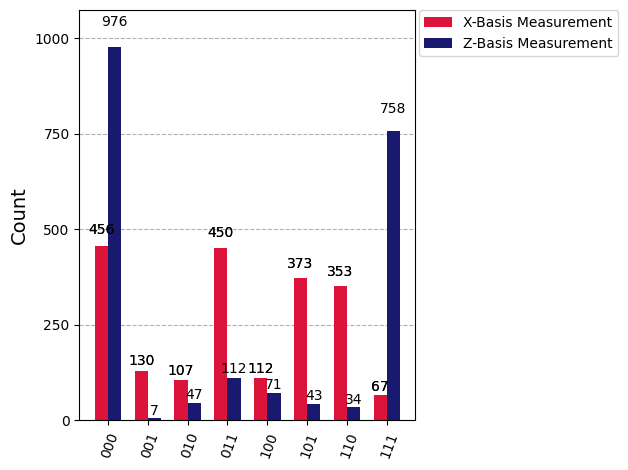

In [ ]:
    from IPython.display import display

    provider = IQMProvider("https://resonance.meetiqm.com",
                          quantum_computer="sirius",
                          token="")
    backend = provider.get_backend()

    qc = ghz_circuit(3)
    #qc = QuantumCircuit(n, n)

    qc_z = measure_z(qc)
    qc_x = measure_x(qc)

    tqc_z = transpile(qc_z, backend)
    tqc_x = transpile(qc_x, backend)

    shots = 2048

    job_z = backend.run(tqc_z, shots=shots)
    job_x = backend.run(tqc_x, shots=shots)

    counts_z = job_z.result().get_counts()
    print(f"Counts for Z: {counts_z}")
    counts_x = job_x.result().get_counts()
    print(f"Counts for X: {counts_x}")

    ghz_states = ["0"*3, "1"*3]
    p_ghz = sum(counts_z.get(s, 0) for s in ghz_states) / shots

    x_corr = parity_expectation(counts_x)

    W = 0.5 - 0.5*(p_ghz + x_corr)

    print(f"Z-population: {p_ghz:.3f}")
    print(f"X-correlation: {x_corr:.3f}")
    print(f"Witness value: {W:.3f}")

    if W < 0:
        print("✅ GME detected")
    else:
        print("❌ Witness inconclusive")


    legend = ['X-Basis Measurement', 'Z-Basis Measurement']
    p = plot_histogram([counts_x, counts_z], legend=legend, color=['crimson','midnightblue'])
    display(p)